In [20]:
# загружаем необходимые библиотеки и инструменты
import numpy as np
import pandas as pd
import geopy.distance

import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package vader_lexicon to C:\Users\Наш
[nltk_data]     компьютер\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [21]:
# фиксируем RANDOM_SEED и версию пакетов
RANDOM_SEED = 42
!pip freeze > requirements.txt

# 1. Загрузка данных и исследование

Загружаем данные в отдельные датасеты. Временно объединяем датасеты для обработки данных на следующих этапах. Помечаем датасеты признаком sample, для дальнейшего разделения перед этапом моделирования. Знакомимся со структурой данных:
- в датасете есть как числовые, так и строковые признаки
- один из признаков является датой - далее переведем его в формат datetime для удобства использования
- есть два признака с одинковым количеством пропусков, скорее всего это одни и те же строки, исходя из количества пропусков будем их заполнять
- среди числовых признаков только average_score напоминает нормальное распределение
- признаки lat и lng визуально и логически непригодны для наших целей, но их можно задействовать при проектировании новых признаков

In [22]:
DATA_DIR = 'data/'
df_train = pd.read_csv(DATA_DIR+'hotels_train.csv')
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv')
sample_submission = pd.read_csv(DATA_DIR+'submission.csv')

df_train['sample'] = 1
df_test['sample'] = 0
df_test['reviewer_score'] = 0

data = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)

In [23]:
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [25]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,sample
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,6.297672,49.442439,2.823803,0.749999
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.902295,3.466325,4.579425,0.433014
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,41.328376,-0.369758,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.625000,48.214662,-0.143372,0.250000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,7.900000,51.499981,0.010607,1.000000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,9.600000,51.516288,4.834443,1.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233,1.000000


array([[<AxesSubplot: title={'center': 'additional_number_of_scoring'}>,
        <AxesSubplot: title={'center': 'average_score'}>,
        <AxesSubplot: title={'center': 'review_total_negative_word_counts'}>],
       [<AxesSubplot: title={'center': 'total_number_of_reviews'}>,
        <AxesSubplot: title={'center': 'review_total_positive_word_counts'}>,
        <AxesSubplot: title={'center': 'total_number_of_reviews_reviewer_has_given'}>],
       [<AxesSubplot: title={'center': 'reviewer_score'}>,
        <AxesSubplot: title={'center': 'lat'}>,
        <AxesSubplot: title={'center': 'lng'}>],
       [<AxesSubplot: title={'center': 'sample'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

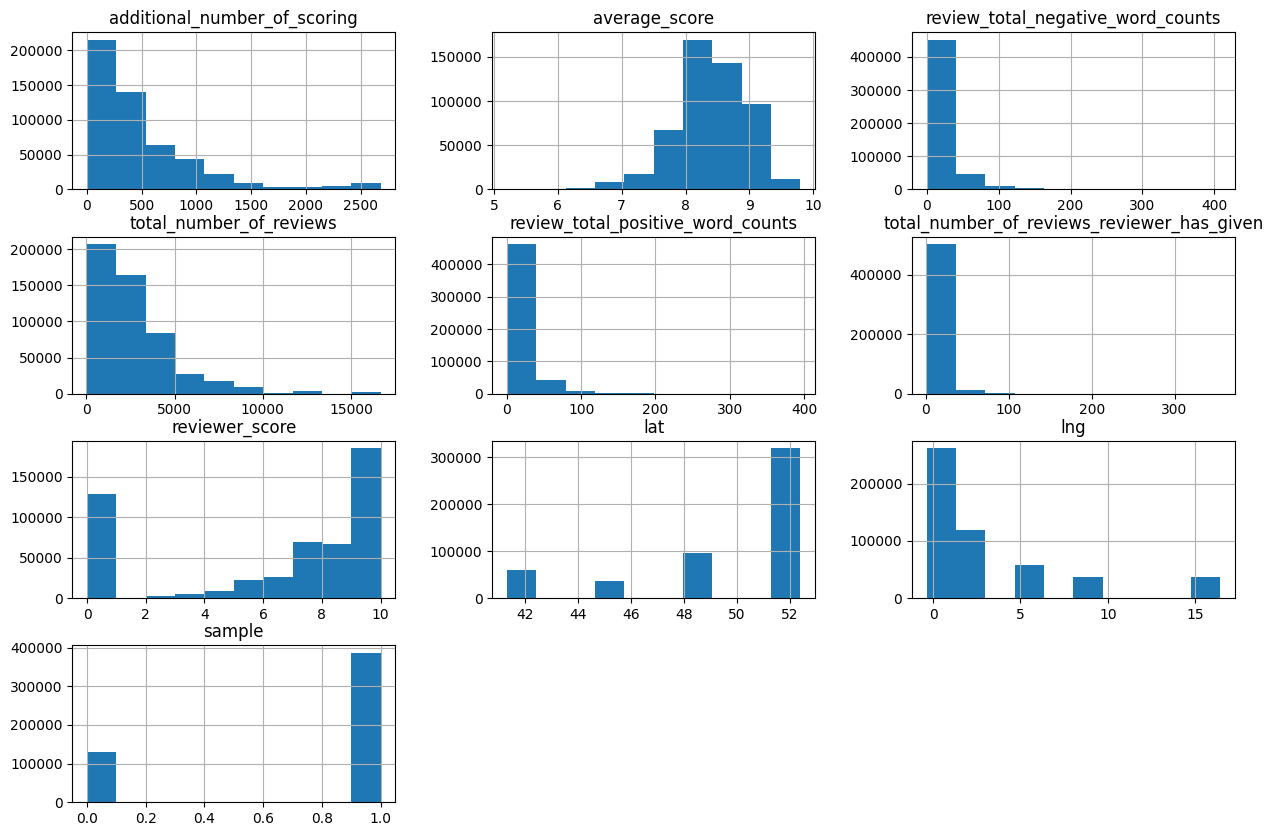

In [26]:
data.hist(figsize=(15,10))

# 2. Очистка данных

## 2.1. Очистка от дубликатов

Анализ списка дубликатов показал, что за дубликаты метод все же принимает строки с отличающимися признаками. При этом метрика улучшается на 0,024% при их удалении. Не исключаю, что метод восприниматет неполные дубликаты, но при этом и сам алгоритм обучения их также воспринимает некорректно. С учетом отсутствия более глубокого понимания принципов работы ML на данном этапе и относительно небольшого количества дубликатов, принимаю решение их удалить.

In [27]:
data.duplicated().sum()

336

In [28]:
# удаляем дубликаты из тренировочного датасета, проверяем результат
df_train.drop_duplicates(inplace=True)
df_train.duplicated().sum()

0

In [29]:
# заново собираем датасет для дальнешей работы
df_train['sample'] = 1
df_test['sample'] = 0
df_test['reviewer_score'] = 0

data = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)

## 2.2. Очистка от пропусков

Проверяем данные на пропуски. Признаки lat и lng имеют по 3268 пропусков. Выясняем, что всего 17 отелей имеют пропуски координат. Заполним их вручную в отдельную таблицу и внесем информацию в датасет.

In [30]:
data.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
dtype: int64

In [31]:
data[data.isnull().any(axis=1)]['hotel_name'].value_counts()

hotel_name
Fleming s Selection Hotel Wien City                 658
Hotel City Central                                  563
Hotel Atlanta                                       389
Maison Albar Hotel Paris Op ra Diamond              290
Hotel Daniel Vienna                                 245
Hotel Pension Baron am Schottentor                  223
Austria Trend Hotel Schloss Wilhelminenberg Wien    194
Derag Livinghotel Kaiser Franz Joseph Vienna        147
NH Collection Barcelona Podium                      146
City Hotel Deutschmeister                            93
Hotel Park Villa                                     61
Cordial Theaterhotel Wien                            57
Holiday Inn Paris Montmartre                         55
Roomz Vienna                                         49
Mercure Paris Gare Montparnasse                      37
Renaissance Barcelona Hotel                          33
Hotel Advance                                        28
Name: count, dtype: int64

In [32]:
#создаем таблицу с именами и адресами отелей для заполнения пропусков
data_nan = data[data.isnull().any(axis=1)][['hotel_name']].value_counts().to_frame()
data_nan.drop('count', axis=1, inplace=True)

# добавляем стобец lat с координатами отелей
data_nan.insert(0, 'lat', [
        48.209367,
        48.213593,
        48.220402,
        48.875289,
        48.188793,
        48.216815,
        48.219565,
        48.245944,
        41.391556,
        48.220851,
        48.233513,
        48.209527,
        48.888909,
        48.186854,
        48.839988,
        41.392709,
        41.383306
])

# добавляем стобец lng с координатами отелей
data_nan.insert(1, 'lng', [
        16.353443,
        16.379880,
        16.355824,
        2.323391,
        16.383790,
        16.359906,
        16.285594,
        16.341843,
        2.177926,
        16.366611,
        16.345645,
        16.351484,
        2.333174,
        16.420715,
        2.323604,
        2.167428,
        2.162869
])

In [33]:
# соединяем таблицы по имени отеля, заполнем пропуски и удаляем присоединенные столбцы
data = data.merge(data_nan, how='left', on='hotel_name', suffixes=(None, '_x'))
data.loc[data.lat.isna(), ['lat']] = data[data.lat.isna()]['lat_x']
data.loc[data.lng.isna(), ['lng']] = data[data.lng.isna()]['lng_x']
data.drop(['lat_x', 'lng_x'], axis=1, inplace=True)

data.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
dtype: int64

# 3. Разведывательный анализ данных

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [35]:
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1


## 3.1. План действий по каждому из нечисловых признаков

- **hotel_address:** извлечь 2 признака - страну (для обучения модели) и город (для дальнейшего вычисления расстояния от центра)
- **review_date:** создать новый признак сезонности
- **hotel_name:** сам по себе признак бесполезен, удаляем (можно выделить сетевые отели, но это очень объемная работа) 
- **reviewer_nationality:** скорее всего полезный признак, приведем к необходимому для кодирования виду
- **negative_review:** измеряем эмоциональную оценку
- **positive_review:** измеряем эмоциональную оценку
- **tags:** анализируем теги, создаем несколько новых признаков
- **days_since_review:** переводим в число (дней)
- **lat и lng:** создаем признак "расстояние до центра города"

## 3.2. Проектирование новых признаков

### hotel_address
Из данного признака можно достать несколько параметров, выясняется что все отели представлены 6 странами по одному городу в каждой, т.к. в данном случае признаки страны и города идентичны, то для обучения остановимся на стране, а город пока оставим для определения координат его центра и создания в дальнейшем признака расстояния отеля до центра. Остальные данные признака не задействуем.

In [36]:
# создаем новые признаки - город и страна
data['country'] = data.hotel_address.apply(lambda x: 'United Kingdom' if 'United' in x.split()[-2] else x.split()[-1])
data['city'] = data.hotel_address.apply(lambda x: 'London' if 'United' in x.split()[-2] else x.split()[-2])

# удаляем исходный признак
data.drop('hotel_address', axis=1, inplace=True)

### review_date
Т.к. у нас нет данных о датах проживания автора отзыва, то идея создать признак "уикенд - да/нет" в данном случае не будет корректным, ведь мы не можем быть уверены когда именно (через сколько дней) был оставлен отзыв. Но мы можем предположить, что отзыв оставлен через несколько дней, максимум через 1-2 недели, поэтому попробуем создать признак сезонности - довольно важный параметр в отельном бизнесе. В среднем по Европе сезонность по месяцам года следующая (в целом как и у нас в РФ) - high (июнь-август), low (декабрь-февраль) и shoulder (март-май, сентябрь-ноябрь).

In [37]:
# создаем новый признак сезонности проживания
data.review_date = pd.to_datetime(data.review_date, format="%m/%d/%Y")
data['season'] = data.review_date.apply(lambda x: 'high' if 6<=x.month<=8 else 'low' if x.month==12 or 1<=x.month<=2 else 'shoulder')

# удаляем исходный признак
data.drop('review_date', axis=1, inplace=True)

### hotel_name
В идеале выделить сети и одиночные, но это очень объемная работа (не всегда имя сети присутствует в названии, есть много "подбрендов" и т.п.), для данного проекта сам по себе признак бесполезен, поэтому удаляем

In [38]:
# удаляем исходный признак
data.drop('hotel_name', axis=1, inplace=True)

### reviewer_nationality
Приведем к необходимому для кодирования виду - удалим лишне пробелы и оставим ТОП-100, а остальные пометим как "другие"

In [39]:
# удаляем пробелы в ячейках
data.reviewer_nationality = data.reviewer_nationality.apply(lambda x: x.strip())

# создаем список ТОП-100
reviewer_top_100 = data.reviewer_nationality.value_counts().nlargest(100)

#корреткируем изначальный признак
data.reviewer_nationality = data.reviewer_nationality.apply(lambda x: x if x in reviewer_top_100 else 'other')

### negative_review
Измеряем эмоциональную оценку при помощи SentimentIntensityAnalyzer. Дальнейшая оценка значимости признаков для модели а также ознакомление с наиболее успешными работами на Kaggle позвоят сделать вывод о том, что признаки negative_review и positive_review, а также тщательная их очистка и подготовка (в т.ч. с помощью других инструментов) позволяют добится наилучших результатов в показателе MAPE.
На данном этапе я принял решение сделать эмоцинальную оценку "сырых" данных и создать на ее основе один признак по параметру 'compound'. 
Далее при желании достигнуть лучших показателей в соревновании следует большую часть усилий прилагать именно к обработке этих признаков.

In [40]:
# 'подгружаем' инструмент оценки
sia = SentimentIntensityAnalyzer()

# создаем новый признак с эмоциональной оценкой отзыва на основе параметра оценки 'compound'
data['negative_sia_score'] = data.negative_review.apply(lambda x: sia.polarity_scores(x)['compound'])

# удаляем исходный признак
data.drop('negative_review', axis=1, inplace=True)

### positive_review
Аналогично поступаем с положительными отзывами

In [41]:
# создаем новый признак с эмоциональной оценкой отзыва на основе параметра оценки 'compound'
data['positive_sia_score'] = data.positive_review.apply(lambda x: sia.polarity_scores(x)['compound'])

# удаляем исходный признак
data.drop('positive_review', axis=1, inplace=True)

### tags
Анализ тэгов привел к следующему заключению - берем наиболее часто встречающиеся и выделяем по типу тэгов 3 дополнительных признака:
- trip_typе - может быть leisure или business, если нет этих тэгов ставим NaN
- mobile_submitt - тэг либо есть, либо его нет (1 или 0)
- guests - разделим на solo, couple, group и with children

Дальнейшая оценка покажет, что данные признаки не сильно эффективны в обучении.

In [42]:
# преобразуем строки с тэгами в списки для дальнейшего анализа и создания новых признаков
data.tags = data.tags.apply(lambda x: x[3:-3].split(" ', ' "))

# посмотрим сколько уникальных тэгов и как часто они встречаются
tags_list = []
for li in data.tags:
    for el in li:
        tags_list.append(el)
        
tags_list = pd.Series(tags_list)
tags_list.value_counts().nlargest(30)

Leisure trip                      417538
Submitted from a mobile device    307470
Couple                            252128
Stayed 1 night                    193568
Stayed 2 nights                   133850
Solo traveler                     108476
Stayed 3 nights                    95761
Business trip                      82884
Group                              65361
Family with young children         60989
Stayed 4 nights                    47777
Double Room                        35207
Standard Double Room               32247
Superior Double Room               31361
Family with older children         26334
Deluxe Double Room                 24812
Double or Twin Room                22393
Stayed 5 nights                    20826
Standard Double or Twin Room       17479
Classic Double Room                16877
Superior Double or Twin Room       13570
2 rooms                            12384
Stayed 6 nights                     9765
Standard Twin Room                  9745
Single Room     

In [43]:
# создаем три новых признака на основе наличия того или иного тэга в записи
data['trip_type'] = data.tags.apply(lambda x: 'leisure' if 'Leisure trip' in x else 'business' if 'Business trip' in x else np.NaN)

data['mobile_submitt'] = data.tags.apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)

data['guest_type'] = data.tags.apply(lambda x: 'solo' if 'Solo traveler' in x else 'couple' if 'Couple' in x else 'group' if 'Group' in x 
                                    else 'with children' if 'Family with older children' in x or 'Family with young children' in x else np.NaN)

# удаляем изначальный признак с тэгами
data.drop('tags', axis=1, inplace=True)

### days_since_review
С логической точки зрения данный признак не должен быть полезен, но на практике он довольно ценен (по графику в конце моделирования) и улучшает метрику на 0,125%. Есть предположение, что он, например, косвенно отображает возраст отеля (т.к. значения довольно большие). А в отельном бизнесе возраст отеля (износ номерного фонда, или наоборот рост популярности и узнаваемости) может играть важную роль. Оставляем признак, вынув из изначального столбца число дней.

In [44]:
# создаем новый столбец review_days и записываем туда число дней из признака
data['review_days'] = data.days_since_review.apply(lambda x: int(x.split()[0]))

# удаляем исходный признак
data.drop('days_since_review', axis=1, inplace=True)

### lat и lng
Используем для вычисления расстояния отеля до центра города, получим координаты центра каждого города и вычислим для каждого отеля расстояние от него. Оценка покажет, что признак довольно полезный.

In [45]:
#запишем координаты центров городов в переменную
city_centre = data.city.value_counts().to_frame()

city_centre.insert(0, 'lat_centre', [
        51.508530,
        41.388790,
        48.853410,
        52.374030,
        48.208490,
        45.464270
])

city_centre.insert(1, 'lng_centre', [
        -0.125740,
        2.158990,
        2.348800,
        4.889690,
        16.372080,
        9.189510,
])

In [46]:
# при помощи функции и инсрумента geopy создаем и заполняем новый признак - расстояние до центра города
def dist_calc(city, lng, lat):
    lng_centre = city_centre['lng_centre'][city]
    lat_centre = city_centre['lat_centre'][city]
    return geopy.distance.geodesic([lng_centre, lat_centre], [lng, lat]).km

data['distance_to_centre'] = data.apply(lambda x: dist_calc(x.city, x.lng, x.lat), axis=1)

# удаляем исходные признаки координат и город
data.drop(['city', 'lat', 'lng'], axis=1, inplace=True)

## 3.3. Преобразование признаков

In [47]:
# признак национальности автора отзыва
bin_enc = ce.BinaryEncoder(cols=['reviewer_nationality'])
data_bin = bin_enc.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, data_bin], axis=1)

# признак страны отеля
ohe_enc = ce.OneHotEncoder(cols=['country'])
data_ohe = ohe_enc.fit_transform(data['country'])
data = pd.concat([data, data_ohe], axis=1)

# признак сезонности
ohe_enc = ce.OneHotEncoder(cols=['season'])
data_ohe = ohe_enc.fit_transform(data['season'])
data = pd.concat([data, data_ohe], axis=1)

# признак типа поездки
ohe_enc = ce.OneHotEncoder(cols=['trip_type'])
data_ohe = ohe_enc.fit_transform(data['trip_type'])
data = pd.concat([data, data_ohe], axis=1)

# признак типа гостей
ohe_enc = ce.OneHotEncoder(cols=['guest_type'])
data_ohe = ohe_enc.fit_transform(data['guest_type'])
data = pd.concat([data, data_ohe], axis=1)

# удаляем исходные признаки
data.drop(['reviewer_nationality', 'country', 'season', 'trip_type', 'guest_type'], axis=1, inplace=True)

## 3.4. Отбор признаков (мультиколлениарность)

По итогам оценки тепловой карты относительно сильная корреляция прослеживается только между признаками additional_number_of_scoring и total_number_of_reviews. Исключение одного из них при обучении на стационарном ПК дает улучшение MAPE на 0,048%. Однако при обучении на Kaggle показатель MAPE ухудшился. Не трогаем эти признаки.

<AxesSubplot: >

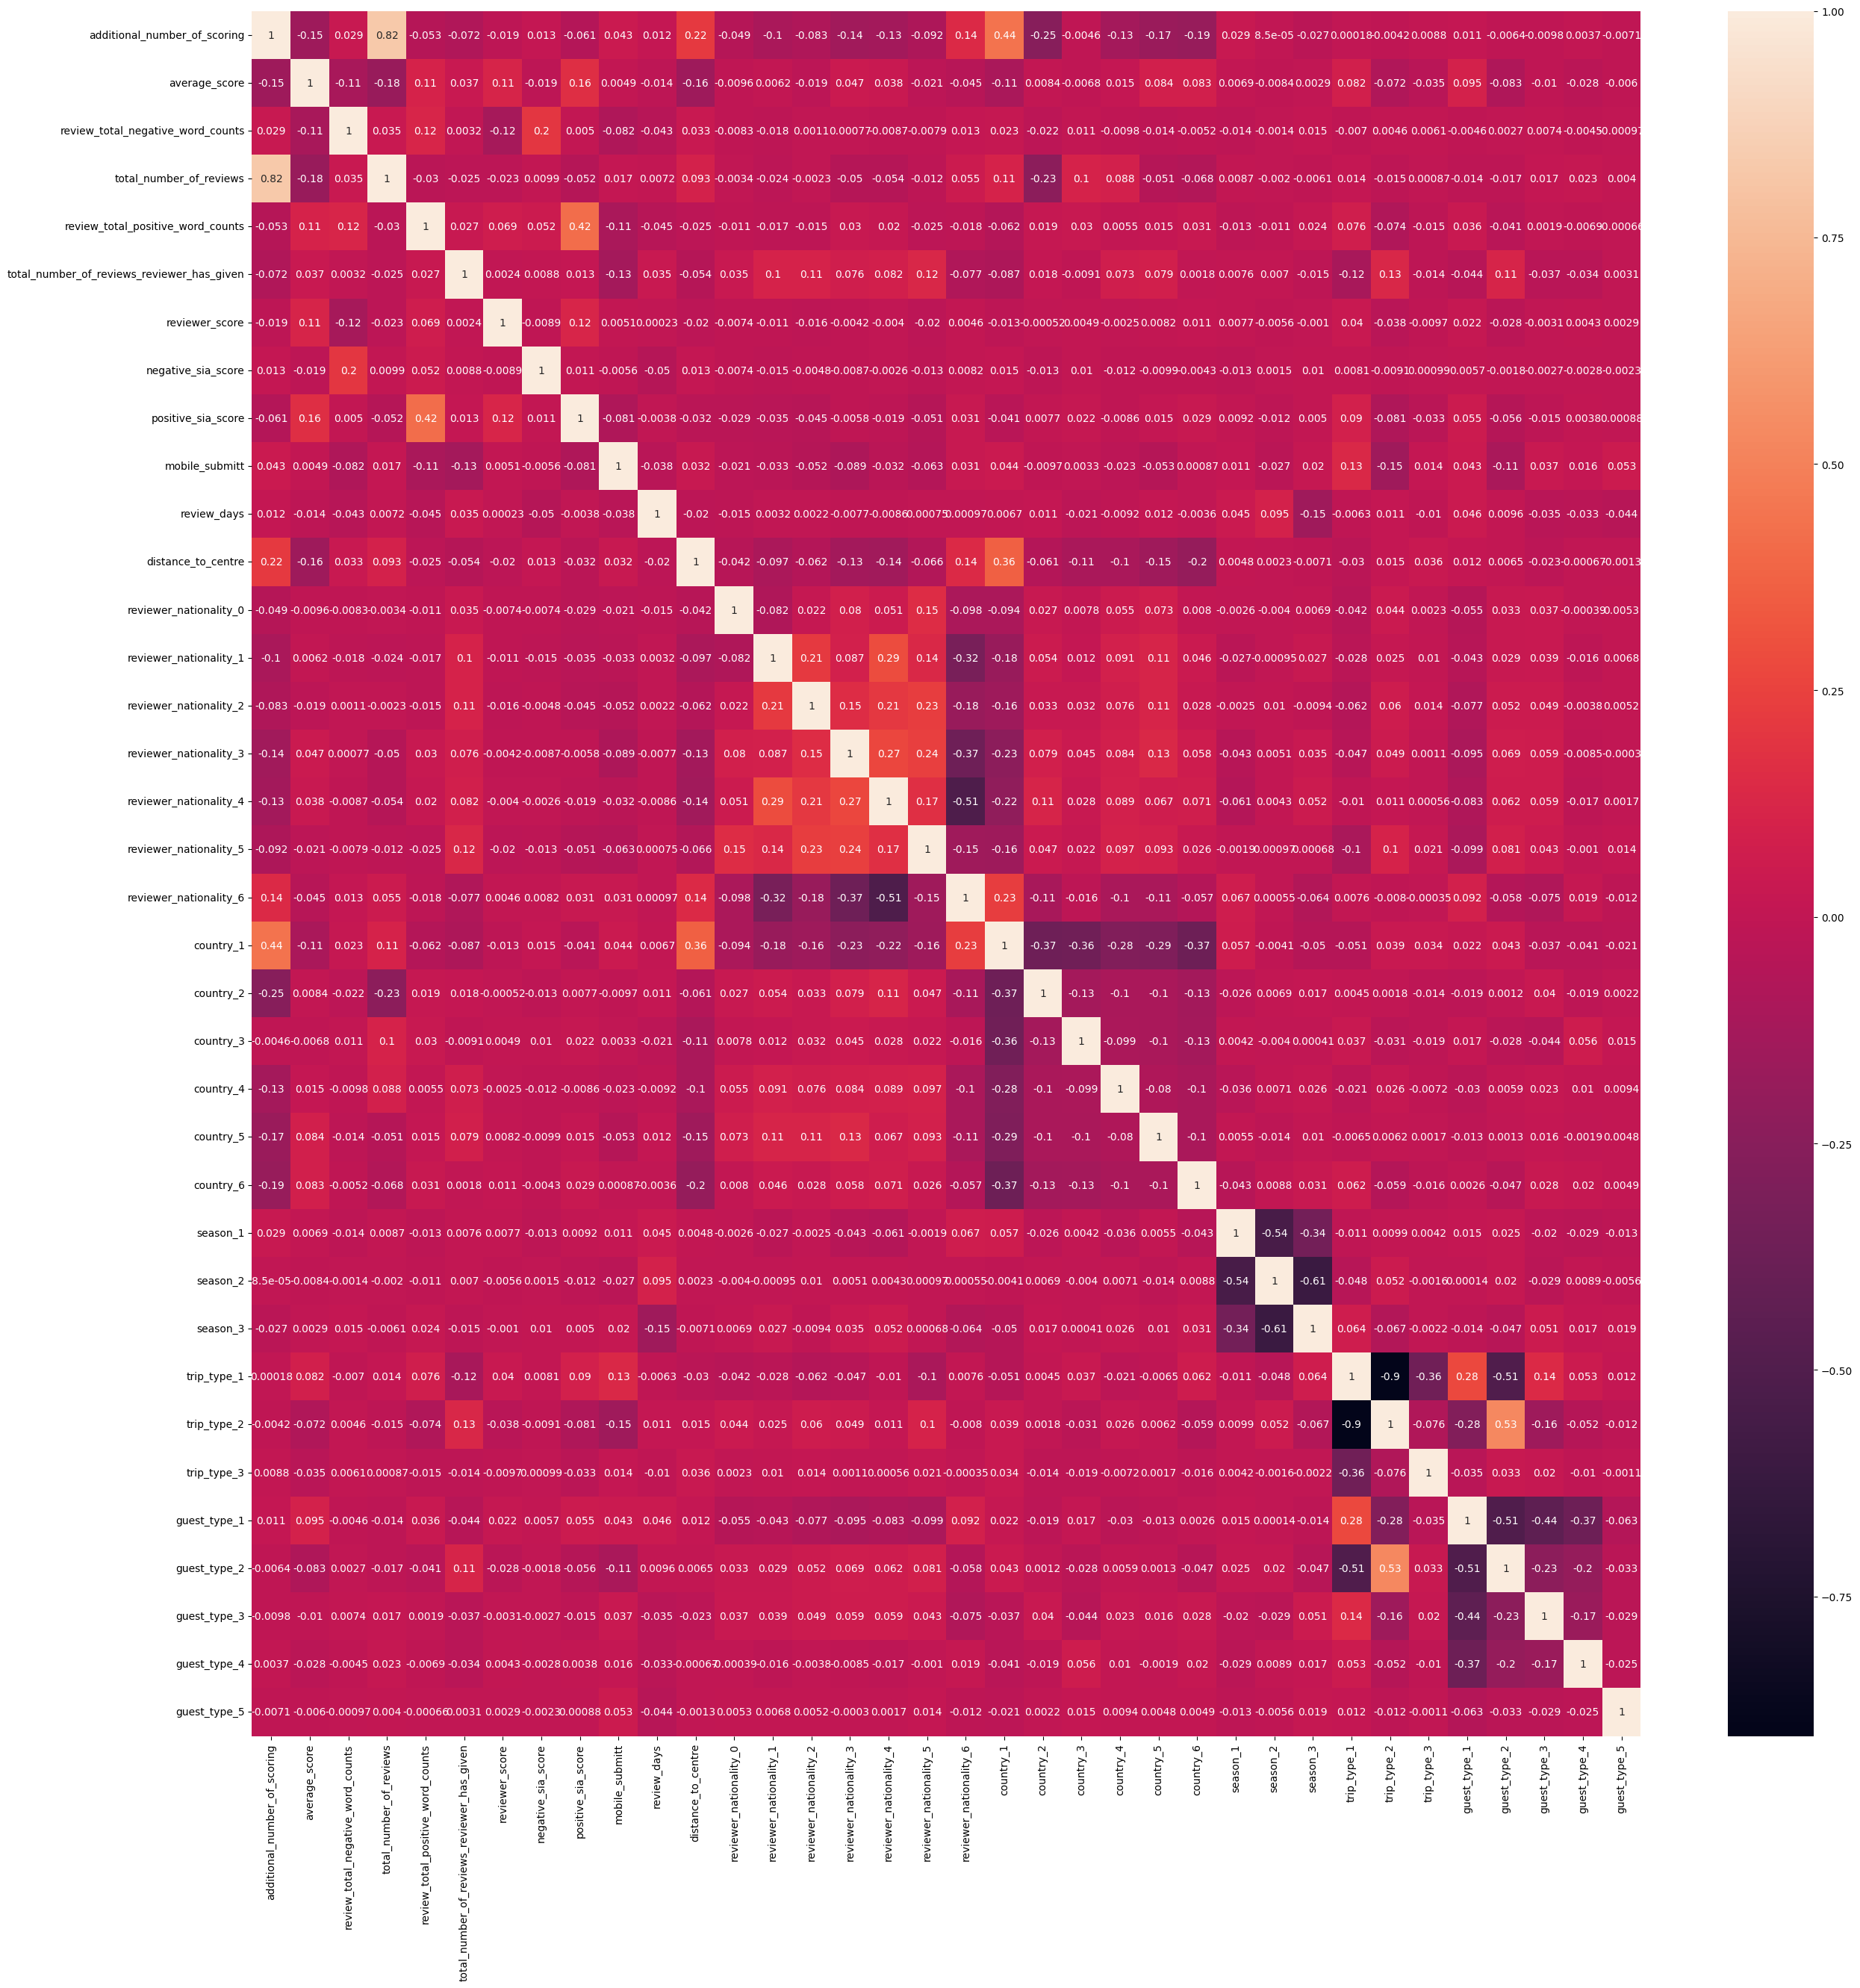

In [48]:
# тепловая карта корреляции признаков
plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

# 4. Моделирование

## 4.1. Подготовка данных

In [49]:
# разделим обратно датасет на тренировочный и тестовый
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values # таргет
X = train_data.drop(['reviewer_score'], axis=1)

# выделим 20% данных на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

## 4.2. Обучение модели и предсказание, оценка MAPE

In [50]:
# создаем модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# предсказываем рейтинг в тестовов датасете и записываем в переменную y_pred
y_pred = model.predict(X_test)

# сравниваем предсказанные значения с реальными, метрика - MAPE
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s


MAPE: 0.12534952556169107


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.5s finished


<AxesSubplot: >

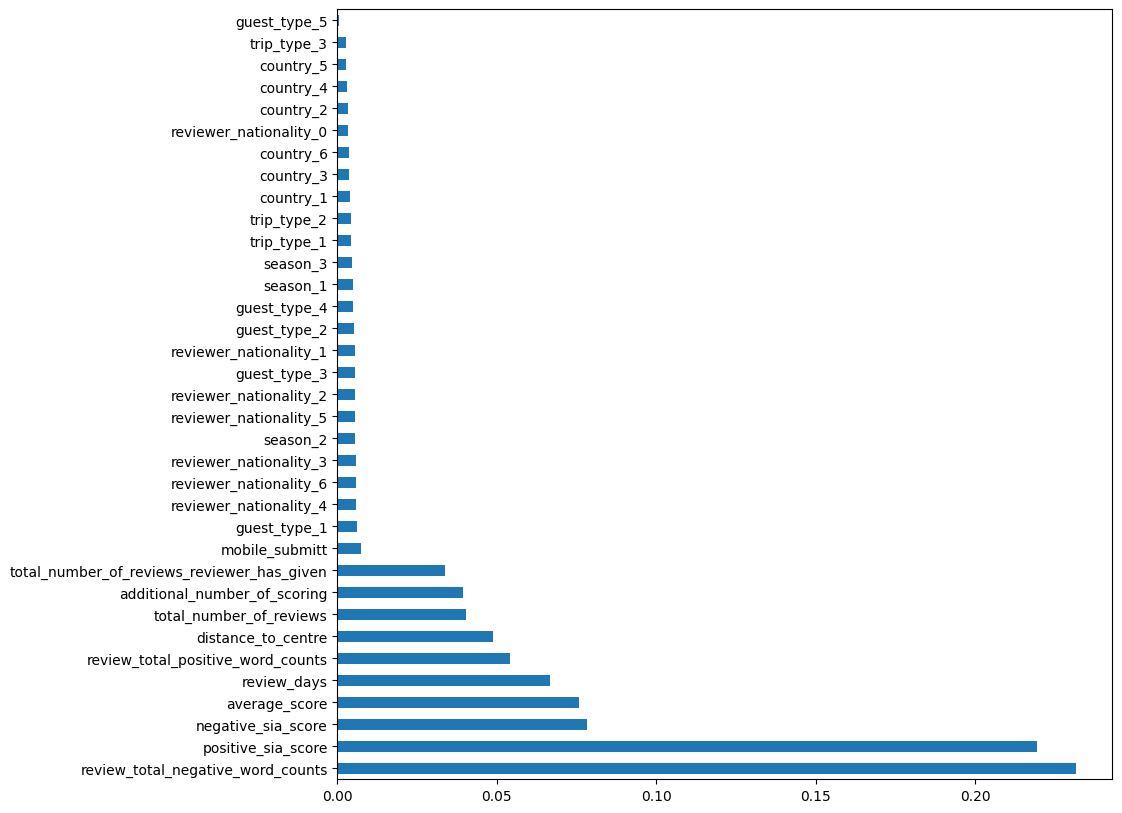

In [51]:
# оцениваем самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')

## 4.3. Прогноз тестовых данных, запись submission для Kaggle

In [52]:
test_data = test_data.drop(['reviewer_score'], axis=1)
sample_submission['reviewer_score'] = model.predict(test_data)
sample_submission.to_csv('submission.csv', index=False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.0s finished
